***
*Course:* [Math 535](http://www.math.wisc.edu/~roch/mmids/) - Mathematical Methods in Data Science (MMiDS)  
*Author:* [Sebastien Roch](http://www.math.wisc.edu/~roch/), Department of Mathematics, University of Wisconsin-Madison  
***

# <span style="background-color:dodgerblue; color:white; padding:2px 6px">APPLICATIONS</span> 
# Dimensionality reduction


*Updated:* March 20, 2020 

*Julia version:* 1.3.1

## Contents

[Recap from the lectures](#Recap-from-the-lectures)

1 [Movie recommendations](#1-Movie-recommendations)

2 [Exploring viral evolution using genetic data](#2-Exploring-viral-evolution-using-genetic-data)

In [1]:
using DataFrames, CSV, Plots, LinearAlgebra, SparseArrays, Statistics, Distances

function mmids_gramschmidt(A)
    n, m = size(A)
    Q = zeros(Float64, n, m)
    R = zeros(Float64, m, m)
    for j = 1:m
        v = A[:,j]
        for k = 1:j-1
            R[k,j] = dot(Q[:,k],A[:,j])
            v -= R[k,j]*Q[:,k]
        end
        R[j,j] = norm(v)
        Q[:,j] = v/R[j,j]
    end
    return Q, R
end

mmids_gramschmidt (generic function with 1 method)

## Recap from the lectures

***The setup*** We are given a data matrix $A \in \mathbb{R}^{n \times d}$ and we want seek to project this data to a lower-dimensional space by computing a low-rank approximation of $A$. Truncating the SVD provides a solution to this problem. The SVD of $A$ is a decomposition of the form:

$$
A = U \Sigma V^T = \sum_{j=1}^r \sigma_j \mathbf{u}_j \mathbf{v}_j^T
$$

where the columns of $U \in \mathbb{R}^{n \times r}$ and those of $V \in \mathbb{R}^{m \times r}$ are orthonormal, and $\Sigma \in \mathbb{R}^{r \times r}$ is a diagonal matrix. Here the $\mathbf{u}_j$'s are the columns of $U$ and are referred to as left singular vectors. Similarly the $\mathbf{v}_j$'s are the columns of $V$ and are referred to as right singular vectors. The $\sigma_j$'s, which are non-negative and in decreasing order 

$$
\sigma_1 \geq \sigma_2 \geq \cdots \geq \sigma_r > 0
$$ 

are the diagonal elements of $\Sigma$ and are referred to as singular values.

***The theory*** Indeed, we established the following. First, recall the following definitions. Define $\mathbb{S}^{m-1} = \{\mathbf{x} \in \mathbb{R}^m\,:\,\|\mathbf{x}\| = 1\}$.

**Definition (Frobenius Norm):** The Frobenius norm of an $n \times m$ matrix $A \in \mathbb{R}^{n \times m}$ is defined as

$$
\|A\|_F
= \sqrt{\sum_{i=1}^n \sum_{j=1}^m a_{ij}^2}.
$$

$\lhd$

**Definition (Induced Norm):** The $2$-norm of a matrix $A \in \mathbb{R}^{n \times m}$ is

$$
\|A\|_2
= \max_{\mathbf{0} \neq \mathbf{x} \in \mathbb{R}^m} \frac{\|A \mathbf{x}\|}{\|\mathbf{x}\|} = \max_{\mathbf{x} \in \mathbb{S}^{m-1}} \|A \mathbf{x}\|.
$$

$\lhd$

***

**Theorem (Low-Rank Approximation in the Induced Norm):** Let $A \in \mathbb{R}^{n \times m}$ be a matrix with SVD

$$
A = \sum_{j=1}^r \sigma_j \mathbf{u}_j \mathbf{v}_j^T
$$

and let $A_k$ be the truncation defined above with $k < r$. For any matrix $B \in \mathbb{R}^{n \times m}$ of rank at most $k$,

$$
\|A - A_k\|_2 \leq \|A - B\|_2.
$$

***

Finally, we justified the use of this projection by the following inequality.

***

**Theorem (Why Project):** Let $A \in \mathbb{A}^{n \times d}$ be a matrix 
and let $A_k$ be the truncation above. For any matrix $C \in \mathbb{R}^{n \times d}$ of rank $\leq k$, 

$$
\|A_k - C\|_F^2 \leq 8 k \|A - C\|_2^2.
$$

***


***The algorithm*** We used the Power Iteration to compute the top singular vectors.

***
**Lemma (Power Iteration):** Let $A \in \mathbb{R}^{n\times m}$ be a matrix with $m \leq n$. Let $U \Sigma V^T$ be an SVD of $A$ such that $\sigma_1 > \sigma_2$. Define $B = A^T A$ and assume that $\mathbf{x} \in \mathbb{R}^m$ is a vector satisfying $\langle \mathbf{v}_1, \mathbf{x} \rangle > 0$. Then

$$
\frac{B^{2k} \mathbf{x}}{\|B^{2k} \mathbf{x}\|} \to \mathbf{v}_1
$$

as $k \to +\infty$.
***

The algorithm is below.

In [2]:
function mmids_svd(A, r; maxiter=1000)
    V = randn(size(A,2),r) # random initialization
    for _ = 1:maxiter
        W = A * V
        Z = A' * W
        V, R = mmids_gramschmidt(Z)
    end
    W = A * V
    S = [norm(W[:, i]) for i=1:size(W,2)] # singular values
    U = reduce(hcat,[W[:,i]/S[i] for i=1:size(W,2)]) # left singular vectors
    return U, S, V
end

mmids_svd (generic function with 1 method)

In this notebook, we give two concrete examples of high-dimensional datasets where projecting to the first few singular vectors appears to preserve much of the structure. 

## 1 Movie recommendations

We first return to the [MovieLens dataset](https://grouplens.org/datasets/movielens/) from the lecture.

In [3]:
dfm = CSV.read("./movielens-small-movies.csv")
first(dfm, 5)

,movieId,title
,Int64,String
1,1,Toy Story (1995)
2,2,Jumanji (1995)
3,3,Grumpier Old Men (1995)
4,4,Waiting to Exhale (1995)
5,5,Father of the Bride Part II (1995)


In [4]:
dfr = CSV.read("./movielens-small-ratings.csv")
first(dfr, 5)

,userId,movieId,rating
,Int64,Int64,Float64
1,1,1,4.0
2,1,3,4.0
3,1,6,4.0
4,1,44,5.0
5,1,47,5.0


Here's a summary of the data. There are $9742$ movies and $100836$ ratings made by $610$ users.

In [5]:
nrow(dfr)

100836

In [6]:
describe(dfm)

,variable,mean,min,median,max
,Symbol,Union…,Any,Union…,Any
1,movieId,4871.5,1,4871.5,9742
2,title,,'71 (2014),,À nous la liberté (Freedom for Us) (1931)


In [7]:
describe(dfr)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Nothing,Nothing,DataType
1,userId,326.128,1,325.0,610,,,Int64
2,movieId,3108.38,1,2255.0,9742,,,Int64
3,rating,3.50156,0.5,3.5,5.0,,,Float64


We will convert the ratings data into a matrix.

We construct a matrix whose rows are the movies and whose columns are the users. Because this matrix contains many zeros, which we use to encode the absence of a rating, we first define it using a [`sparse`](https://docs.julialang.org/en/v1/stdlib/SparseArrays/#man-csc-1) array (that is, we only list the non-zero entries).

In [8]:
A = sparse(dfr[:,:movieId],dfr[:,:userId],dfr[:,:rating])

9742×610 SparseMatrixCSC{Float64,Int64} with 100836 stored entries:
  [1   ,   1]  =  4.0
  [3   ,   1]  =  4.0
  [6   ,   1]  =  4.0
  [44  ,   1]  =  5.0
  [47  ,   1]  =  5.0
  [63  ,   1]  =  3.0
  [90  ,   1]  =  5.0
  [98  ,   1]  =  4.0
  [125 ,   1]  =  5.0
  [131 ,   1]  =  5.0
  [137 ,   1]  =  5.0
  [185 ,   1]  =  5.0
  ⋮
  [9343, 610]  =  3.0
  [9358, 610]  =  4.0
  [9360, 610]  =  4.0
  [9367, 610]  =  3.5
  [9390, 610]  =  3.5
  [9391, 610]  =  3.5
  [9393, 610]  =  5.0
  [9434, 610]  =  4.0
  [9435, 610]  =  4.0
  [9462, 610]  =  5.0
  [9463, 610]  =  5.0
  [9464, 610]  =  5.0
  [9504, 610]  =  3.0

Next, we extract the movie titles.

In [9]:
movie_titles = dfm[:,:title]

9742-element WeakRefStrings.StringArray{String,1}:
 "Toy Story (1995)"                                      
 "Jumanji (1995)"                                        
 "Grumpier Old Men (1995)"                               
 "Waiting to Exhale (1995)"                              
 "Father of the Bride Part II (1995)"                    
 "Heat (1995)"                                           
 "Sabrina (1995)"                                        
 "Tom and Huck (1995)"                                   
 "Sudden Death (1995)"                                   
 "GoldenEye (1995)"                                      
 "American President, The (1995)"                        
 "Dracula: Dead and Loving It (1995)"                    
 "Balto (1995)"                                          
 ⋮                                                       
 "Hommage à Zgougou (et salut à Sabine Mamou) (2002)"    
 "Gintama (2017)"                                        
 "Gintama: The Movie 

Before running our SVD algorithm, we preprocess our data. We first remove all movies without ratings. We also replace all missing ratings with the average rating of the corresponding movie. Finally, we center the ratings by subtracting the mean rating of each user.

In [10]:
## PRE-PROCESSING of A 
## OUTPUT: Z, movie_titles_Z, mZ

# restrict to rows with at least one rating
nnz_movies = findall(s -> s > 0, vec(sum(A,dims=2)))
Z = copy(Array{Float64,2}(A[nnz_movies,:]))

# for each missing rating, replace with mean rating of corresponding movie
for i=1:size(Z,1)
    nnz_ratings_for_i = findall(r -> r > 0, Z[i,:])
    z_ratings_for_i = findall(r -> r == 0, Z[i,:])
    Z[i,z_ratings_for_i] .= mean(Z[i,nnz_ratings_for_i])
end

# for each user, center ratings
mZ = zeros(Float64, size(Z,2))
for j=1:size(Z,2)
    mZ[j] = mean(Z[:,j])
    Z[:,j] .-= mZ[j]
end

# update movie titles
movie_titles_Z = movie_titles[nnz_movies];

We use our SVD algorithm to compute the top 10 singular vectors and plot the corresponding singular values.

In [11]:
U, S, V = mmids_svd(Z, 10);

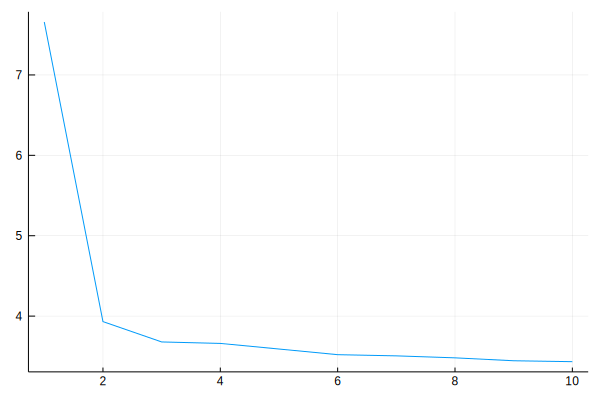

In [12]:
plot(log.(S), legend=false)

We notice that the singular values drop quickly, suggesting that the data can be well approximated by a low-dimensional projection. We test this next by making movie recommendations based on data projected on the top two singular vectors. We first complete the ratings matrix.

In [13]:
k = 2
Apred = U[:,1:k]*Diagonal(S[1:k])*V[:,1:k]'

# for each user, de-center the ratings
for j=1:size(Z,2)
    Apred[:,j] .+= mZ[j]
end

Apred

9724×610 Array{Float64,2}:
 4.18849   3.91528  3.86205  3.80214  3.89599  …  3.71851   3.88548  4.41991 
 3.68423   3.42621  3.37616  3.31902  3.40784     3.23847   3.39822  3.90222 
 3.40837   3.25656  3.22678  3.19499  3.24615     3.14618   3.24065  3.53431 
 2.36991   2.35725  2.35445  2.35462  2.35698     2.34527   2.35729  2.37487 
 3.12941   3.07051  3.05848  3.0488   3.06706     3.02763   3.06517  3.17483 
 4.01658   3.94495  3.92996  3.91883  3.94094  …  3.89655   3.93803  4.07354 
 3.22452   3.18472  3.17625  3.17139  3.18277     3.15639   3.18153  3.25348 
 2.884     2.8752   2.87281  2.87487  2.87545     2.86832   2.87559  2.88594 
 3.17497   3.12424  3.11374  3.10613  3.12144     3.08762   3.11983  3.21335 
 3.63182   3.49331  3.46591  3.43778  3.48403     3.39375   3.47887  3.7464  
 3.76199   3.66974  3.65101  3.63438  3.66404  …  3.60496   3.66052  3.83664 
 2.47688   2.42003  2.40881  2.39841  2.41644     2.37583   2.41504  2.52012 
 3.13751   3.12518  3.12196  3.12363 

For background on using SVD to make movie recommendations, see e.g. [here](http://files.grouplens.org/papers/webKDD00.pdf). For a discussion of other methods, see e.g. [here](https://cims.nyu.edu/~cfgranda/pages/OBDA_fall17/notes/matrix_factorization.pdf).

## 2 Exploring viral evolution using genetic data

We now consider another application of dimensionality reduction, this time in biology. We will look at SNP data from viruses. A little background first. From [Wikipedia](https://en.wikipedia.org/wiki/Single-nucleotide_polymorphism):

> A single-nucleotide polymorphism (SNP; /snɪp/; plural /snɪps/) is a substitution of a single nucleotide that occurs at a specific position in the genome, where each variation is present at a level of more than 1% in the population. For example, at a specific base position in the human genome, the C nucleotide may appear in most individuals, but in a minority of individuals, the position is occupied by an A. This means that there is a SNP at this specific position, and the two possible nucleotide variations – C or A – are said to be the alleles for this specific position.

Some details about our dataset. Quoting [Jombart et al., BMC Genetics (2010)](https://bmcgenet.biomedcentral.com/articles/10.1186/1471-2156-11-94), we analyze:

> the population structure of seasonal influenza A/H3N2 viruses using hemagglutinin (HA) sequences. Changes in the HA gene are largely responsible for immune escape of the virus (antigenic shift), and allow seasonal influenza to persist by mounting yearly epidemics peaking in winter. These genetic changes also force influenza vaccines to be updated on a yearly basis. [...] Assessing the genetic evolution of a pathogen through successive epidemics is of considerable epidemiological interest. In the case of seasonal influenza, we would like to ascertain how genetic changes accumulate among strains from one winter epidemic to the next. For this purpose, we retrieved all sequences of H3N2 hemagglutinin (HA) collected between 2001 and 2007 available from Genbank. Only sequences for which a location (country) and a date (year and month) were available were retained, which allowed us to classify strains into yearly winter epidemics. Because of the temporal lag between influenza epidemics in the two hemispheres, and given the fact that most available sequences were sampled in the northern hemisphere, we restricted our analysis to strains from the northern hemisphere (latitudes above 23.4°north). The final dataset included 1903 strains characterized by 125 SNPs which resulted in a total of 334 alleles. All strains from 2001 to 2007 were classified into six winter epidemics (2001-2006). This was done by assigning all strains from the second half of the year with those from the first half of the following year. For example, the 2005 winter epidemic comprises all strains collected between the 1st of July 2005 and the 30th of June 2006.

We first load the data. It contains a subset of $1642$ strains from the dataset above. 

In [14]:
dfsnp = CSV.read("./h3n2-snp.csv")
first(dfsnp, 5)

,strain,s6a,s6c,s6g,s17a,s17g,s17t,s39a,s39c
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,AB434107,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AB434108,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,CY000113,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CY000209,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,CY000217,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
nrow(dfsnp)

1642

We extract a data matrix, run our SVD algorithm with $k=2$, and plot the data in the projected subspace of the first two singular vectors.

In [16]:
A = reduce(hcat, [dfsnp[:,col] for col in names(dfsnp)[2:end]])

1642×317 Array{Float64,2}:
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0

In [17]:
U, S, V = mmids_svd(A, 2);

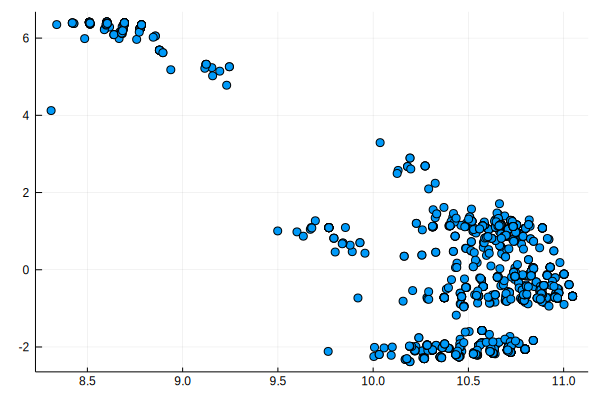

In [18]:
scatter(U[:,1].*S[1], U[:,2].*S[2], legend = false)

There seems to be some reasonably well-defined clusters in this projection. To further reveal the structure, we color the data points by year. That information is in a separate file. 

In [19]:
dfoth = CSV.read("./h3n2-other.csv")
first(dfoth, 5)

,strain,length,country,year,lon,lat,date
,String,Int64,String,Int64,Float64,Float64,String
1,AB434107,1701,Japan,2002,137.215,35.5842,2002/02/25
2,AB434108,1701,Japan,2002,137.215,35.5842,2002/03/01
3,CY000113,1762,USA,2002,-73.94,40.67,2002/01/29
4,CY000209,1760,USA,2002,-73.94,40.67,2002/01/17
5,CY000217,1760,USA,2002,-73.94,40.67,2002/02/26


In [20]:
year = dfoth[:,:year];

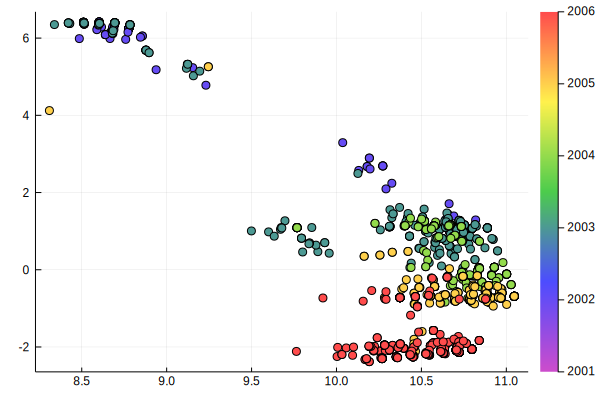

In [21]:
scatter(U[:,1].*S[1], U[:,2].*S[2], marker_z=year, legend=false,
    colorbar=:right, clims=(2001,2006), seriescolor=:lightrainbow)

To some extent, one can "see" the virus evolving from year to year.

One last note: in this case [better results](https://bmcgenet.biomedcentral.com/articles/10.1186/1471-2156-11-94/figures/8) can be obtained using other related dimensionality reduction methods. 